In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.model_selection import train_test_split

# Build Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Imputation and Scaling"
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

# Feature Selection 
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectFromModel, SelectPercentile, RFE

# Feature Decomposition and Extraction
from sklearn.decomposition import PCA

# Model 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

# Results
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

# GridSearchCV 
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Save model weights ---- > pickle package or joblib package
import joblib

/Users/boajang/miniforge3/envs/ml/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("train.csv")
external_df = pd.read_csv("test.csv")

In [3]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
categorical_features = ['Pclass','Sex','SibSp','Embarked']
numerical_features = ['Age','Fare']
print(f'Categorical Data: {len(categorical_features)}\nNumerical Data: {len(numerical_features)}')

Categorical Data: 4
Numerical Data: 2


In [5]:
""" Setting Variables """
random_state = 42

fontsize = 15
title_font = 16
small_font = 12
mean_color = '#1a50b6'
data_dir = 'external' 

label_dict = {0:'No',1:'Yes'}

X_features = categorical_features + numerical_features # clinical_feature + blood_serum_feature + pleural_fluid_feature
Y_target = 'Survived'
print(f'Number of Features Uses: {len(X_features)}')

Number of Features Uses: 6


In [6]:
""" Set X(Data) and Y(Target) """
X = df.loc[:, X_features]
feature_col = X.columns
Y = df.loc[:, Y_target]
print(f"Feature: {X.shape} | Target: {Y.shape}")

Feature: (891, 6) | Target: (891,)


In [7]:
""" TRAIN AND TEST DATASET SPLIT """
test_size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=test_size, shuffle=True, 
                                                    stratify=Y, random_state=random_state)

print(f'Train: {len(x_train)} | Test: {len(x_test)}\n')

for idx, v in label_dict.items():
    print(f'{v} | Train: {y_train.value_counts()[idx]} | Test: {y_test.value_counts()[idx]}')

""" Set X(Data) and Y(Target) for external """
x_external = external_df.loc[:, X_features]
print(f"\nExternal Feature: {x_external.shape}")

Train: 712 | Test: 179

No | Train: 439 | Test: 110
Yes | Train: 273 | Test: 69

External Feature: (418, 6)


# Pipeline

- sklearn.base의 TransformerMixin을 상속하면 fit, transform메서드만 만들어도 자동으로 fit_transform()메서드를 자동으로 생성해준다.
- sklearn.base의 BaseEstimator를 상속하면 하이퍼파라미터 튜닝에 필요한 두 메서드 get_params()와 set_params()를 추가로 얻게 된다. (생성자에 *args나 **kargs 사용하면 안됨)

In [8]:
class FeatureSpliter( BaseEstimator, TransformerMixin ):
    """ 변수 나누어주는 Class 
    수치형(Numerical) 데이터와 범주형(Categorical) 데이터를 선택하기 위한 클래스
    """
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X[self.feature_names]

In [9]:
""" 결측치 대체 Class """
class MissingTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self, imputer='single', strategy='mean'):
        self.imputer = imputer
        self.strategy = strategy

    def fit( self, X, y = None ):
        if (self.imputer == 'single') or (self.imputer == SimpleImputer()):
            self.imputer = SimpleImputer(missing_values=np.nan, strategy=self.strategy)
            if self.strategy not in ['mean', 'median', 'most_frequent', 'constant']:
                raise ValueError(f" >>> Can only use these strategies: ['mean', 'median', 'most_frequent', 'constant'], got strategy = {self.strategy}")
        elif self.imputer == 'multiple':
            if (self.strategy == 'knn') or (self.imputer == KNNImputer()):
                self.imputer = KNNImputer(missing_values=np.nan, n_neighbors=2)
            elif (self.strategy == 'iterative') or (self.imputer == IterativeImputer()):
                self.imputer = IterativeImputer(estimator=LinearRegression(), missing_values=np.nan, max_iter=10, verbose=2, 
                                                imputation_order='roman',random_state=random_state, n_nearest_features=5)
            else: 
                raise ValueError(f" >>> Can only use these strategies: ['knn', 'iterative'], got strategy = {self.strategy}")
                
        self.imputer = self.imputer.fit(X)      
        return self
    
    def transform(self, X , y = None ):
        # cols = X.columns.tolist()
        result = self.imputer.transform(X)
        # result = pd.DataFrame(result , columns=cols)
        return result

In [10]:
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    """ 범주형 변수 처리 Class """
    def __init__(self, encoder ='ordinal'):
        self.encoder = encoder
        
    def fit( self, X, y = None ):
        if (self.encoder == 'ordinal') or (self.encoder == OrdinalEncoder()):
            self.encoder = OrdinalEncoder()
        # elif self.encoder == 'onehot':
        #     self.encoder = OneHotEncoder()
        # elif (self.encoder == 'label') or (self.encoder == LabelEncoder()):
        #     self.encoder = LabelEncoder()
        else:
            raise ValueError(f" >>> Can only use these encoders : ['ordinal'], got encoder = {self.encoder}") # 'onehot', 'label'
            
        self.encoder = self.encoder.fit(X)
        return self
    
    def transform(self, X , y = None ):
        # cols = X.columns.to_list()
        result = self.encoder.transform(X)
        # result = pd.DataFrame(result, columns=cols)
        return result

In [11]:
class NumericalTransformer( BaseEstimator, TransformerMixin ):
    """ 연속형 변수 처리 Class """
    def __init__(self, scaler='minmax'):
        self.scaler = scaler
            
    def fit( self, X, y = None ):
        if (self.scaler == 'minmax') or (self.scaler == MinMaxScaler()):
            self.scaler = MinMaxScaler()
        elif (self.scaler == 'standard') or (self.scaler == StandardScaler()):
            self.scaler = StandardScaler()
        elif (self.scaler == 'normalize') or (self.scaler == Normalizer()):
            self.scaler = Normalizer()
        elif (self.scaler == 'robust') or (self.scaler == RobustScaler()):
            self.scaler = RobustScaler()
        else:
            raise ValueError(f" >>> Can only use these scalers : ['minmax', 'standard', 'normalize', 'robust'], got scaler = {self.scaler}")
            
        self.scaler = self.scaler.fit(X)
        return self
    
    def transform(self, X , y = None):
        # cols = X.columns.to_list()
        result = self.scaler.transform(X)
        # result = pd.DataFrame(result, columns=cols)
        return result

** Feature Selection **
- 단일 변수 선택법은 각각의 독립변수를 하나만 사용한 예측모형의 성능을 이용하여 가장 분류성능 혹은 상관관계가 높은 변수만 선택하는 방법
    - chi2: 카이제곱 검정 통계값
    - f_classif: 분산분석(ANOVA) F검정 통계값
    - mutual_info_classif: 상호정보량(mutual information)
- feature_selection 서브패키지는 성능이 좋은 변수만 사용하는 전처리기인 SelectKBest 클래스도 제공
- ** For regression: f_regression, mutual_info_regression **
- ** For classification: chi2, f_classif, mutual_info_classif **

In [12]:
class FeatureSelector( BaseEstimator, TransformerMixin ):
    """ Feature Selection Class """
    def __init__(self, selector='chi2', k=10):
        self.selector = selector
        self.k = k
            
    def fit( self, X, y=None):
        if (self.selector == 'chi2'): # filter method
            score_func = chi2
            self.selector = SelectKBest(score_func=score_func, k=self.k)
        elif (self.selector == 'anova'): # filter method
            score_func = f_classif
            self.selector = SelectKBest(score_func=score_func, k=self.k)
        elif (self.selector == 'mutualinfo'): # filter method
            score_func = mutual_info_classif
            self.selector = SelectKBest(score_func=score_func, k=self.k)
        elif (self.selector == 'model-based'): # model-based, embedded method
            model_sel = RandomForestClassifier(n_estimators=100, random_state=random_state).fit(X, y)
            self.selector = SelectFromModel(model_sel, prefit=True, max_features=self.k)
        else:
            raise ValueError(f" >>> Can only use these selectors : ['chi2', 'anova', 'mutualinfo','model-based'], got selector = {self.selector}")
        
        self.selector = self.selector.fit(X, y)
        return self
    
    def transform(self, X , y=None):
        result = self.selector.transform(X)
        return result
    
    def get_feature_name(self): # Get Selected Feature Name
        return self.selector.get_feature_names_out(input_features=feature_col)
    
    def get_support(self):
        return self.selector.get_support()

# Results Visualization

In [13]:
# # from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# def show_confusion_matrix(y_test, y_pred, save_path=None, dataset=None):
#     conf_matrix = confusion_matrix(y_test, y_pred)
    
#     cmap = plt.cm.Blues
#     plt.figure(figsize=(6,6))
#     plt.imshow(conf_matrix, cmap=cmap, interpolation='nearest')

#     thresh = conf_matrix.max() / 1.5 
#     for i in range(conf_matrix.shape[0]):
#         for j in range(conf_matrix.shape[1]):
#             plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', color="white" if conf_matrix[i, j] > thresh else "black",fontsize=fontsize) # , size='large'

#     plt.xticks(np.arange(len(label_dict)), label_dict.values(), fontsize=fontsize, rotation=45)
#     plt.yticks(np.arange(len(label_dict)), label_dict.values(), fontsize=fontsize, rotation=45)
#     plt.xlabel('Predictions', fontsize=fontsize)
#     plt.ylabel('Actuals', fontsize=fontsize)
#     plt.title(f'Confusion matrix: {dataset}', fontsize=title_font)
#     plt.colorbar(fraction=0.05, pad=0.05)
#     if save_path:
#         plt.savefig(f'{save_path}/Confusion_Matrix_{dataset}.png', bbox_inches='tight')
#     plt.show()
#     plt.close()

In [14]:
def show_confusion_matrix(y_test, y_pred, save_path=None, dataset=None):
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix = conf_matrix/conf_matrix.sum(1, keepdims=True) # np.divide(conf_matrix, conf_matrix.sum(1, keepdims=True))

    cmap = plt.cm.Blues
    plt.figure(figsize=(6,6))
    plt.imshow(conf_matrix, cmap=cmap, interpolation='nearest')

    thresh = conf_matrix.max() / 1.5 
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(x=j, y=i,s=round(conf_matrix[i, j], 2), va='center', ha='center', color="white" if conf_matrix[i, j] > thresh else "black",fontsize=fontsize) # , size='large'

    plt.xticks(np.arange(len(label_dict)), label_dict.values(), fontsize=fontsize, rotation=45)
    plt.yticks(np.arange(len(label_dict)), label_dict.values(), fontsize=fontsize, rotation=45)
    plt.xlabel('Predictions', fontsize=fontsize)
    plt.ylabel('Actuals', fontsize=fontsize)
    plt.title(f'Confusion matrix: {dataset}', fontsize=title_font)
    plt.colorbar(fraction=0.05, pad=0.05)
    if save_path:
        plt.savefig(f'{save_path}/Confusion_Matrix_{dataset}.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [15]:
# from sklearn.inspection import permutation_importance

def show_permutation_importance(model, x, y, save_path=None, dataset=None):
    """ 
    >>> PERMUTATION IMPORTANCE <<<  
    > fix_model : 훈련된 모델
    > X_train : 훈련데이터 Feature
    > y_train : 훈련데이터 Target
    > n_repeats : 특정 Feature 를 몇번 Shuffle 할 것인지
    > scoring : Feature 를 Shuffler 한 뒤, 예측값과 실제값을 어떤 Metric 을 사용해 비교할지
    > random_state : 난수 고정
    """
    result = permutation_importance(model, x, y, n_repeats=10,
                                    random_state=random_state, n_jobs=2)
    
    sorted_result = result.importances_mean.argsort()
    # 결과를 DataFrame 화
    importances = pd.DataFrame(result.importances_mean[sorted_result], index=feature_col[sorted_result]).sort_values(0, ascending=False)   
    
    # 결과를 시각화
    plt.figure(figsize=(9,6))
    top_index = sorted_result[-20:]
    plt.boxplot(result.importances[top_index].T, vert=False, labels=feature_col[top_index])
    plt.title(f"Permutation Importances: TOP 20 ({dataset})", fontsize=title_font)
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}/Permutation_Importance_{dataset}.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [16]:
def show_roc_curve(model, x_test, y_test, save_path=None, dataset=None):
    """ ROC & AUC """
    y_true = pd.get_dummies(y_test).to_numpy()
    y_proba = model.predict_proba(x_test)

    fprs = []
    tprs = []
    aucs = []

    fig, ax = plt.subplots(figsize=(10, 7))#, dpi=dpi)
    mean_fpr = np.linspace(0,1,100)
    for k, v in label_dict.items():
        fpr, tpr, _ = roc_curve(y_true[:, k], y_proba[:, k])
        auc_score = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc_score)

        line = ax.plot(fpr, tpr, label=f'{label_dict[k]} (AUC=%0.2f)'%auc_score, alpha=0.3)

    ax.plot([0, 1], [0, 1], 'r--', label='Chance', alpha=0.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    # print("Mean roc_auc_score: ", roc_auc_score(y_true, y_proba, multi_class='macro'))
    ax.plot(mean_fpr, mean_tpr, color=mean_color, label='Mean ROC (AUC=%0.2f $\pm$ %0.2f)'%(mean_auc, std_auc), alpha=0.8)


    ax.legend(fontsize=small_font, ncol=1, loc='lower right')
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(f'Receiver Operating Characteristic (ROC) Curve: {dataset}', fontsize=title_font)
    plt.tight_layout()
    if save_path:
        plt.savefig(f'{save_path}/ROC_Curve_{dataset}.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [17]:
def set_preprocessing(cat_feature=None, cat_encoder = 'ordinal', cat_imputer = 'single', cat_strategy = 'most_frequent', num_feature=None, num_scaler = 'minmax', num_imputer = 'single', num_strategy = 'mean'):
    """ PipeLine: 
    >>> Feature Selector: Categorical or Numerical
    >>> Imputer: Frequent or Mean
    >>> Scaler: Normalization
    """

    """ CREATE PREPROCESSING STEPS FOR CATEGORICAL PIPELINE """
    categorical_steps = [
        ('cat_selector', FeatureSpliter(cat_feature)),
        ('cat_encoder', CategoricalTransformer(encoder=cat_encoder)), 
        ('cat_imputer', MissingTransformer(imputer=cat_imputer, strategy=cat_strategy)),
    ]

    """ CREATE PREPROCESSING STEPS FOR NUMERICAL PIPELINE """
    numerical_steps = [
        ('num_selector', FeatureSpliter(num_feature)),
        ('num_imputer', MissingTransformer(imputer=num_imputer, strategy=num_strategy)),
        ('num_scaler', NumericalTransformer(scaler=num_scaler)),
    ]

    # create the 2 pipelines with the respective steps
    categorical_pipeline = Pipeline(categorical_steps)
    numerical_pipeline = Pipeline(numerical_steps)

    pipeline_list = [
        ('categorical_pipeline', categorical_pipeline),
        ('numerical_pipeline', numerical_pipeline)
    ]
    # Combining the 2 pieplines horizontally into one full pipeline
    preprocessing_pipeline = FeatureUnion(transformer_list=pipeline_list)
    
    return preprocessing_pipeline

In [18]:
def set_model(network):
    if network == 'Multinomial':
        model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = random_state)
    elif network == 'Decision':
        model = DecisionTreeClassifier(criterion='entropy', random_state=random_state)
    elif network == 'SVC':
        model = SVC(random_state = random_state)
    elif  network == 'RF':
        model = RandomForestClassifier(n_estimators = 1000, random_state = random_state)
    elif network == 'SGD':
        model = SGDClassifier(random_state = random_state)
    elif network == 'XGB': # Good
        model = XGBClassifier(random_state = random_state)
    elif network == 'LGB': # Best
        model = LGBMClassifier(random_state = random_state)
    elif network == 'KNN': 
        model = KNeighborsClassifier(n_neighbors = 7)
    elif network == 'Naive':
        model = GaussianNB()
    elif network == 'Gradient': # Good 
        model = GradientBoostingClassifier(random_state = random_state)
    elif network == 'Cat': # Good 
        model = CatBoostClassifier(random_state = random_state)
    elif network == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu',solver='adam',batch_size=100,random_state=random_state)
    # elif network == 'Logistic':
    #     model = LogisticRegression(random_state = random_state)
    else: 
        raise ValueError(f" >>> Can only use these estimators : ['Multinomial', 'Decision', 'SVC', 'RF', 'SGD', 'XGB', 'LGB', 'KNN', 'Naive', 'Gradient', 'Cat', 'MLP'], got estimator = {network}")
    
    return model 

In [19]:
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

class EstimatorSelector( BaseEstimator, TransformerMixin ):
    def __init__(self, estimator='Multinomial'):
        self.estimator = estimator
            
    def fit(self, X, y):
        if (self.estimator == 'Multinomial') or (self.estimator == LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = random_state)):
            self.estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state = random_state)
        elif (self.estimator == 'Decision') or (self.estimator == DecisionTreeClassifier(criterion='entropy', random_state=random_state)):
            self.estimator = DecisionTreeClassifier(criterion='entropy', random_state=random_state)
        elif (self.estimator == 'SVC') or (self.estimator == SVC(random_state = random_state)):
            self.estimator = SVC(random_state = random_state)
        elif (self.estimator == 'RF') or (self.estimator == RandomForestClassifier(n_estimators = 1000, random_state = random_state)):
            self.estimator = RandomForestClassifier(n_estimators = 1000, random_state = random_state)
        elif (self.estimator == 'SGD') or (self.estimator == SGDClassifier(random_state = random_state)):
            self.estimator = SGDClassifier(random_state = random_state)
        elif (self.estimator == 'XGB') or (self.estimator == XGBClassifier(random_state = random_state)): # Good
            self.estimator = XGBClassifier(random_state = random_state)
        elif (self.estimator == 'LGB') or (self.estimator == LGBMClassifier(random_state = random_state)): # Best
            self.estimator = LGBMClassifier(random_state = random_state)
        elif (self.estimator == 'KNN') or (self.estimator == KNeighborsClassifier(n_neighbors = 7)): 
            self.estimator = KNeighborsClassifier(n_neighbors = 7)
        elif (self.estimator == 'Naive') or (self.estimator == GaussianNB()):
            self.estimator = GaussianNB()
        elif (self.estimator == 'Gradient') or (self.estimator == GradientBoostingClassifier(random_state = random_state)): # Good 
            self.estimator = GradientBoostingClassifier(random_state = random_state)
        elif (self.estimator == 'Cat') or (self.estimator == CatBoostClassifier(random_state = random_state)): # Good 
            self.estimator = CatBoostClassifier(random_state = random_state)
        elif (self.estimator == 'MLP') or (self.estimator == MLPClassifier(hidden_layer_sizes=(100,), activation='relu',solver='adam',batch_size=100,random_state=random_state)):
            self.estimator = MLPClassifier(hidden_layer_sizes=(100,), activation='relu',solver='adam',batch_size=100,random_state=random_state)
        # elif (self.estimator == 'Logistic') or (self.estimator == LogisticRegression(random_state = random_state)):
        #     self.estimator = LogisticRegression(random_state = random_state)
        else: 
            raise ValueError(f" >>> Can only use these estimators : ['Multinomial', 'Decision', 'SVC', 'RF', 'SGD', 'XGB', 'LGB', 'KNN', 'Naive', 'Gradient', 'Cat', 'MLP'], got estimator = {self.estimator}")
            
        self.estimator.fit(X,y)
        return self

    def predict(self, X):
        y_pred = self.estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        score = self.estimator.score(X, y)
        return score

    def predict_proba(self, X):
        proba = self.estimator.predict_proba(X)
        return proba

# Model 

In [20]:
""" SELECT VARIABLES AND CREATE PIPELINE """
cat_encoder = 'ordinal'
cat_imputer = 'single' # 'single' 'multiple'
cat_strategy = 'most_frequent' # 'most_frequent' 'knn'
num_scaler = 'robust' # 'minmax' 'standard' 'normalize' 'robust'
num_imputer = 'single' # 'single' 'multiple'
num_strategy = 'mean' # 'mean' 'iterative'
preprocessing_pipe = set_preprocessing(categorical_features, cat_encoder, cat_imputer, cat_strategy, numerical_features, num_scaler, num_imputer, num_strategy)

network = 'RF'
# model_pipe = set_model(network)
model_pipe  = EstimatorSelector(estimator=network)

In [21]:
# Set model pipeline
pipeline = Pipeline([('Processing', preprocessing_pipe),
                  ('Model', model_pipe),
                 ])
pipeline

Pipeline(steps=[('Processing',
                 FeatureUnion(transformer_list=[('categorical_pipeline',
                                                 Pipeline(steps=[('cat_selector',
                                                                  FeatureSpliter(feature_names=['Pclass',
                                                                                                'Sex',
                                                                                                'SibSp',
                                                                                                'Embarked'])),
                                                                 ('cat_encoder',
                                                                  CategoricalTransformer()),
                                                                 ('cat_imputer',
                                                                  MissingTransformer(strategy='most_frequent'))])),
                  

In [22]:
""" Model Train """
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
y_pred_external = pipeline.predict(x_external)

In [25]:
print(f'>>> Current Model: {network} <<<')
print(f'>>> Current Scaler: {num_scaler} <<<')
print(f'>>> Current Imputer: {num_imputer} <<<')
print(f'Number of Train Dataset: {len(x_train)}')
print(f'Number of Test Dataset: {len(x_test)}')
print(">>> Train Accuracy / Weighted F1-Score: {:.4f} / {:.4f}".format(pipeline.score(x_train, y_train), f1_score(y_train, pipeline.predict(x_train), average='weighted')))
print(">>> Test Accuracy / Weighted F1-Score: {:.4f} / {:.4f}".format(pipeline.score(x_test, y_test), f1_score(y_test, y_pred, average='weighted')))
print(classification_report(y_test, y_pred, target_names=list(label_dict.values())))

>>> Current Model: RF <<<
>>> Current Scaler: robust <<<
>>> Current Imputer: single <<<
Number of Train Dataset: 712
Number of Test Dataset: 179
>>> Train Accuracy / Weighted F1-Score: 0.9831 / 0.9831
>>> Test Accuracy / Weighted F1-Score: 0.8156 / 0.8142
              precision    recall  f1-score   support

          No       0.83      0.87      0.85       110
         Yes       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



In [24]:
save_df = pd.DataFrame([external_df['PassengerId'], y_pred_external]).T
save_df.rename(columns={"Unnamed 0":"Survived"}, inplace=True)
save_df.to_csv("Submit.csv",index=False)

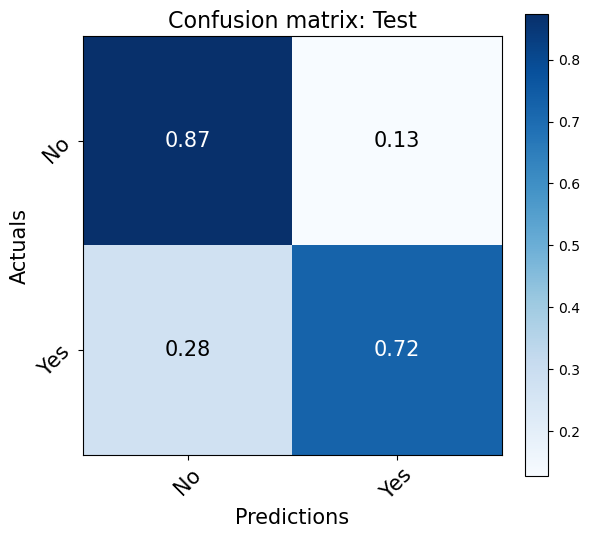

In [26]:
show_confusion_matrix(y_test, y_pred, dataset='Test')
# show_confusion_matrix(y_external, y_pred_external, dataset='External')

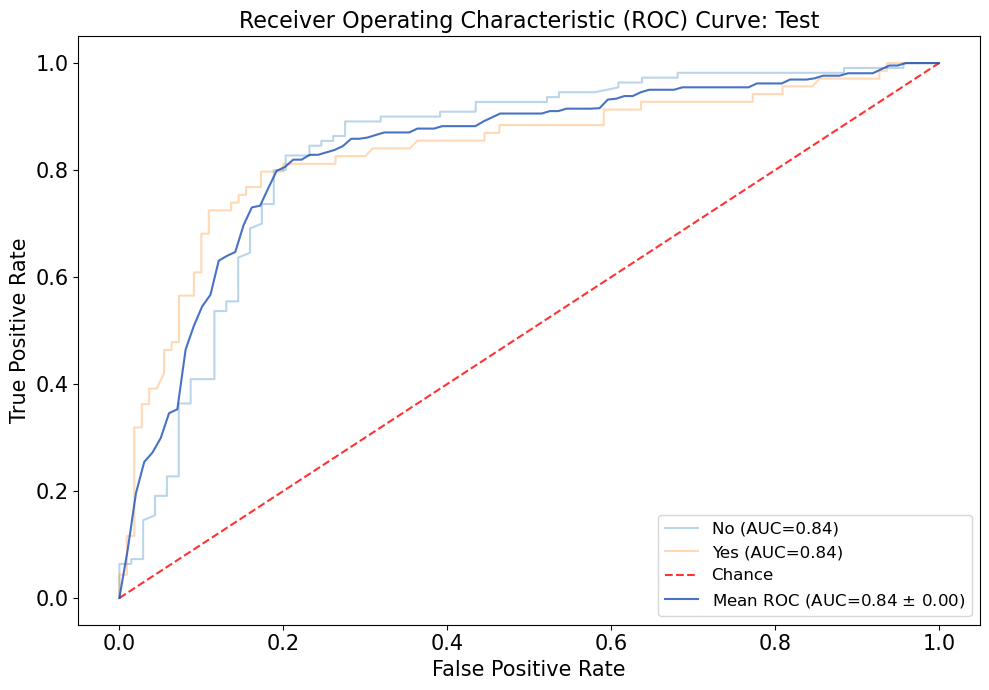

In [33]:
show_roc_curve(pipeline, x_test, y_test, dataset='Test')
# show_roc_curve(pipeline, x_external, y_external, dataset='External')

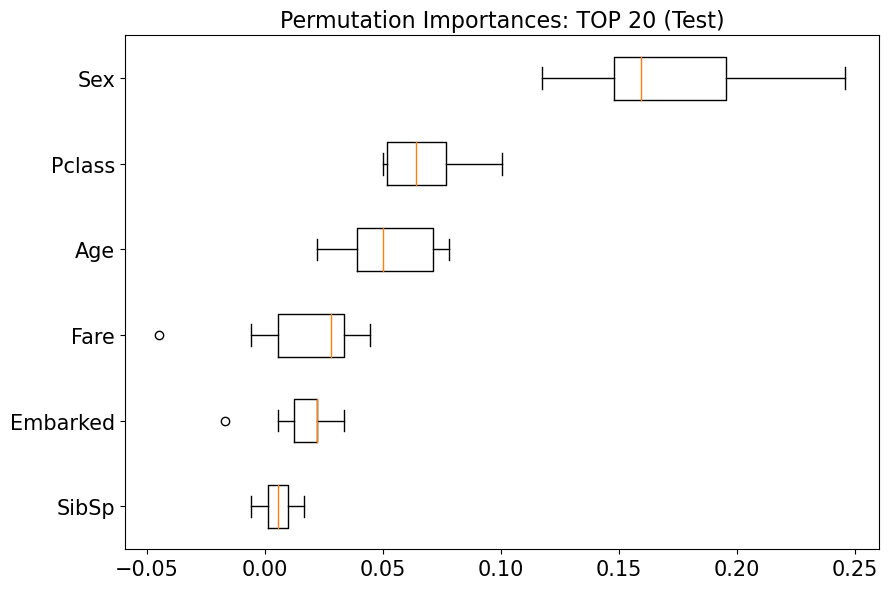

NameError: name 'y_external' is not defined

In [26]:
show_permutation_importance(pipeline, x_test, y_test, dataset='Test')
# show_permutation_importance(pipeline, x_external, y_external, dataset='External')